Домашнее задание «Модели авторегрессии условной гетероскедантичности»

1.  Выберите ряд из первого задания.
2.  Постройте его модель GARCH.
3.  Оформите отчёт в Jupyter-ноутбук.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## Warning ingrone

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Functions

In [4]:
def tsplot(y, lags=None, figsize=(10, 6), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y,
                               lags=lags,
                               ax=pacf_ax,
                               alpha=0.05,
                               method='ywm')

        plt.tight_layout()
    return

In [5]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

## Load data

In [6]:
# Загрузим данные
df = pd.read_csv('Series\weekly-closings-of-the-dowjones-.csv',
                 parse_dates=[0],
                 index_col=0)

series = df.reset_index().iloc[:, -1]


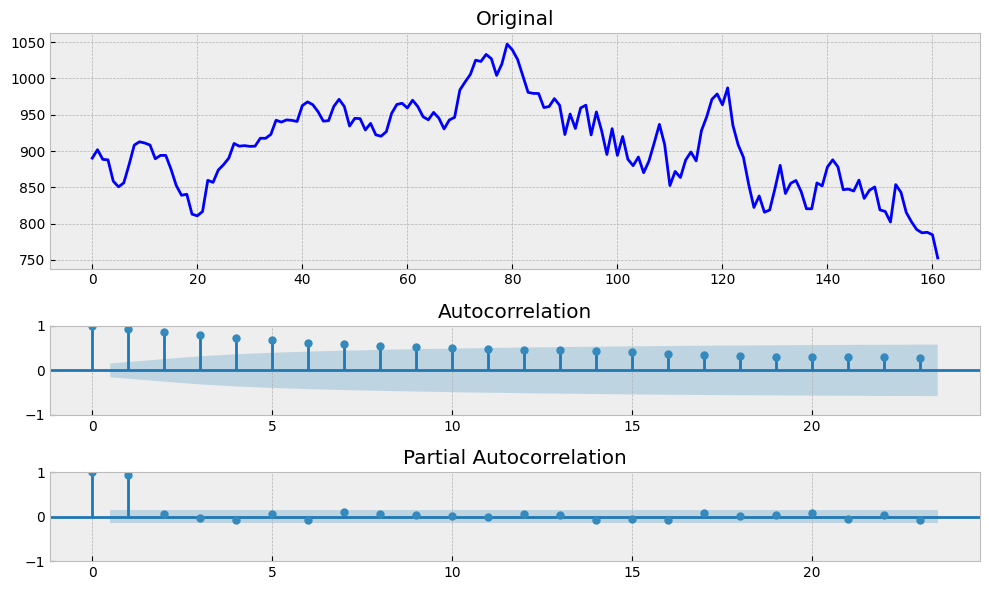

In [7]:
tsplot(series)

## GARCH

Сначала найдем значение p o q в моделе Arima

In [9]:
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                # tmp_mdl = sm.tsa.arima.ARIMA(series, order=(i,d,j),trend='t').fit(method='innovations_mle')
                tmp_mdl = ARIMA(series, order=(i, d, j),
                                trend='c').fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
                    print('aic: {:6.5f} | order: {} | mdl: {}'.format(best_aic, best_order, best_mdl))
            except:
                continue
print('result:')
print('aic: {:6.5f} | order: {} | mdl: {}'.format(best_aic, best_order, best_mdl))

aic: 1792.52410 | order: (0, 0, 0) | mdl: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x00000179885A70D0>
aic: 1635.93129 | order: (0, 0, 1) | mdl: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001798833E860>
aic: 1571.65682 | order: (0, 0, 2) | mdl: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001798833D090>
aic: 1516.13495 | order: (0, 0, 3) | mdl: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001798833F940>
aic: 1499.84022 | order: (0, 0, 4) | mdl: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001798833F7C0>
aic: 1432.78082 | order: (1, 0, 0) | mdl: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001798833F910>
aic: 1431.00068 | order: (3, 0, 3) | mdl: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001798833E1D0>
aic: 1430.95746 | order: (4, 0, 2) | mdl: <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001798841B4F0>
result:
aic: 1430.95746 | order:

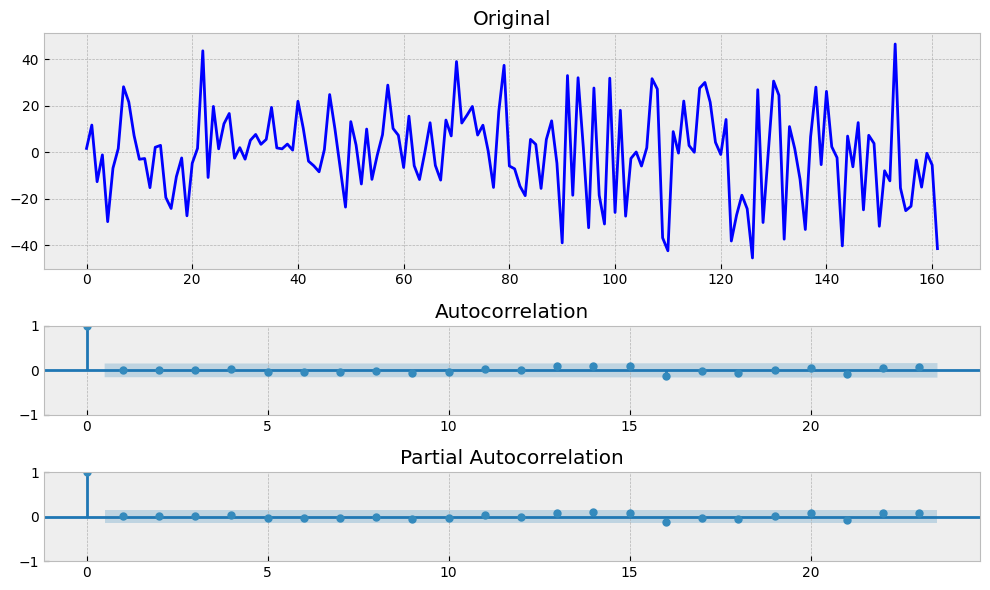

In [10]:
tsplot(best_mdl.resid)

In [11]:
test_stationarity(best_mdl.resid)

Results of Dickey-Fuller Test:
Test Statistic                -1.235257e+01
p-value                        5.781010e-23
#Lags Used                     0.000000e+00
Number of Observations Used    1.610000e+02
Critical Value (1%)           -3.471633e+00
Critical Value (5%)           -2.879665e+00
Critical Value (10%)          -2.576434e+00
dtype: float64


Применим GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [84]:
from arch import arch_model

In [166]:
series_ = series.diff(12).diff(1).dropna().reset_index(drop=True)
train_data = series_[:-10]
test_data = series_[-11:]

# Now we can fit the arch model using the best fit arima model parameters
p_ = 4
o_ = 0
q_ = 2

# Using student T distribution usually provides better fit
am = arch_model(train_data, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -653.476
Distribution:      Standardized Student's t   AIC:                           1316.95
Method:                  Maximum Likelihood   BIC:                           1331.62
                                              No. Observations:                  139
Date:                      Wed, Apr 12 2023   Df Residuals:                      138
Time:                              21:16:52   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

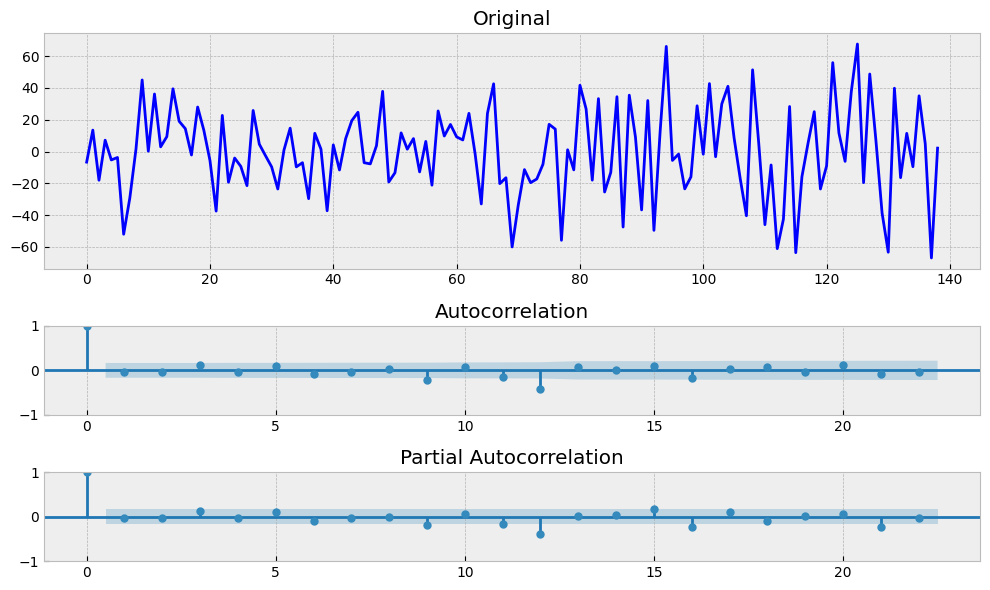

In [176]:
tsplot(res.resid)

Проведем предсказания

In [167]:
forecast = res.forecast(horizon=11,start=0, method='simulation')

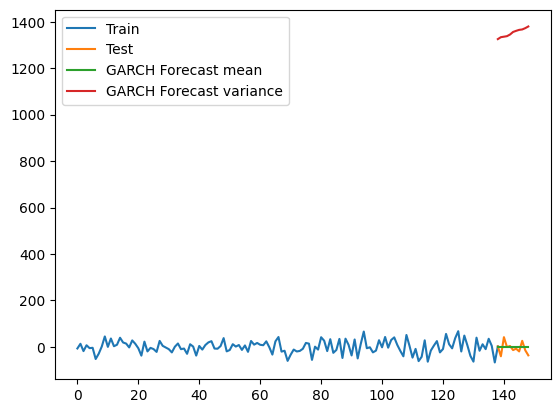

In [172]:
predictions_mean = pd.Series(data=forecast.mean.iloc[-1].values, index = test_data.index)
predictions_var = pd.Series(data=forecast.residual_variance.iloc[-1].values, index = test_data.index)


# визуализация прогноза и реальных значений
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(predictions_mean, label='GARCH Forecast mean')
plt.plot(predictions_var, label='GARCH Forecast variance')
plt.legend()
plt.show()